In [3]:
import os
import numpy as np
import torch
import torchvision
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms as T

In [4]:
# Download a pretrained model
model0 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# maskrcnn_resnet50_fpn
model1 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# retinanet_resnet50_fpn
model2 = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# ssdlite320_mobilenet_v3_large
model3 = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)

# Inference
model0.eval()
model1.eval()
model2.eval()
model3.eval()

/Users/fneba/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fneba/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/fneba/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [5]:
# Defing PyTorch Transform
transform = T.Compose([lambda x: x.convert("RGB"), T.ToTensor()])

# Define class names from MS-COCO dataset

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]



In [6]:
def get_detection(img, model, threshold=0.5):
    pred = model([img]) # Pass the image to the model

    # pred is a list and each element of that list is a dictionary with keys: "labels", "scores", and "boxes"
    pred_classes = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Classes
    
    # !!!! Complete the following (edited the next 3 lines)
    pred_boxes =  pred[0]['boxes'].detach().numpy()  # Get the Prediction Boxes
    pred_scores =  pred[0]['scores'].detach().numpy()  # Get the Prediction Scores
    
    high_score_indices = [i for i, score in enumerate(pred_scores) if score > threshold]
    if high_score_indices:
        last_index = high_score_indices[-1] + 1 
        pred_boxes = pred_boxes[:last_index]
        pred_classes = pred_classes[:last_index]
    else:
        pred_boxes = np.array([])  # In case no scores are above threshold
        pred_classes = []
    
    return pred_boxes, pred_classes

In [7]:
def show_detections(img_path, model, threshold=0.5):
    img = Image.open(img_path) # Load the image
    img = transform(img) # Apply the transform to the image
    boxes, pred_cls = get_detection(img, model, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    # !!!! Complete the following
    # write code to display the image, overlay the bounding boxes and predicted classes on top of the image
    fig, ax = plt.subplots(figsize=(12, 8))  # Set up the figure and axes
    ax.imshow(img)
    # !!!!
    for box, cls in zip(boxes, pred_cls):
        x, y, xmax, ymax = box
        width = xmax - x
        height = ymax - y
        # Draw a rectangle around each box
        rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # Add label
        ax.text(x, y, cls, verticalalignment='top', color='white', fontsize=10, backgroundcolor='red')
    plt.show()

--2024-05-11 21:26:31--  https://www.tejasgokhale.com/images/vehicle.png
Resolving www.tejasgokhale.com (www.tejasgokhale.com)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to www.tejasgokhale.com (www.tejasgokhale.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581854 (568K) [image/png]
Saving to: ‘vehicle.jpg’

vehicle.jpg         100%[===================>] 568.22K  --.-KB/s    in 0.04s   

2024-05-11 21:26:31 (12.7 MB/s) - ‘vehicle.jpg’ saved [581854/581854]



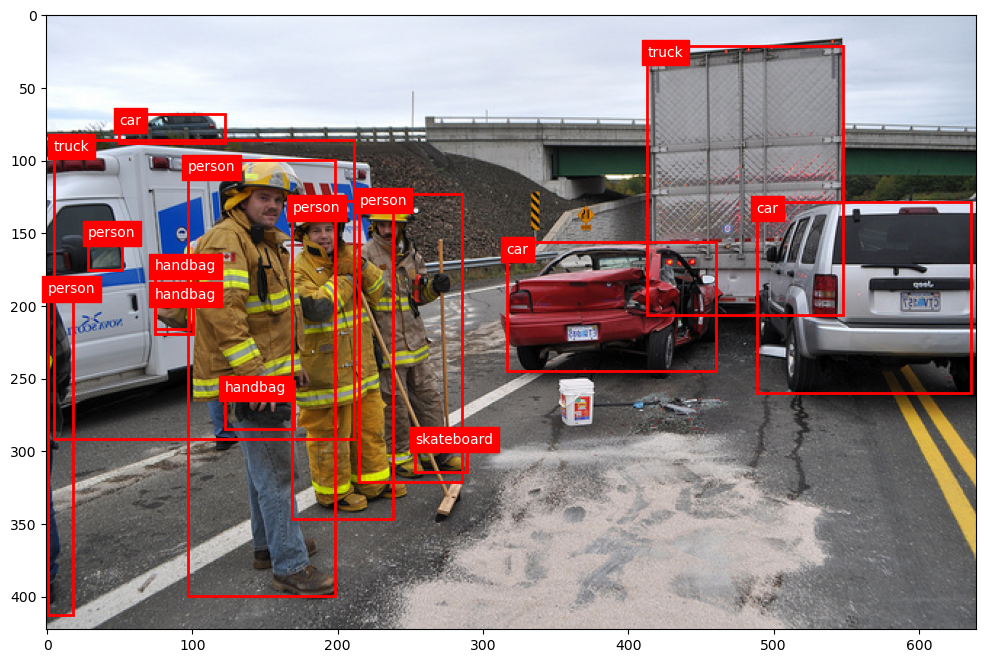

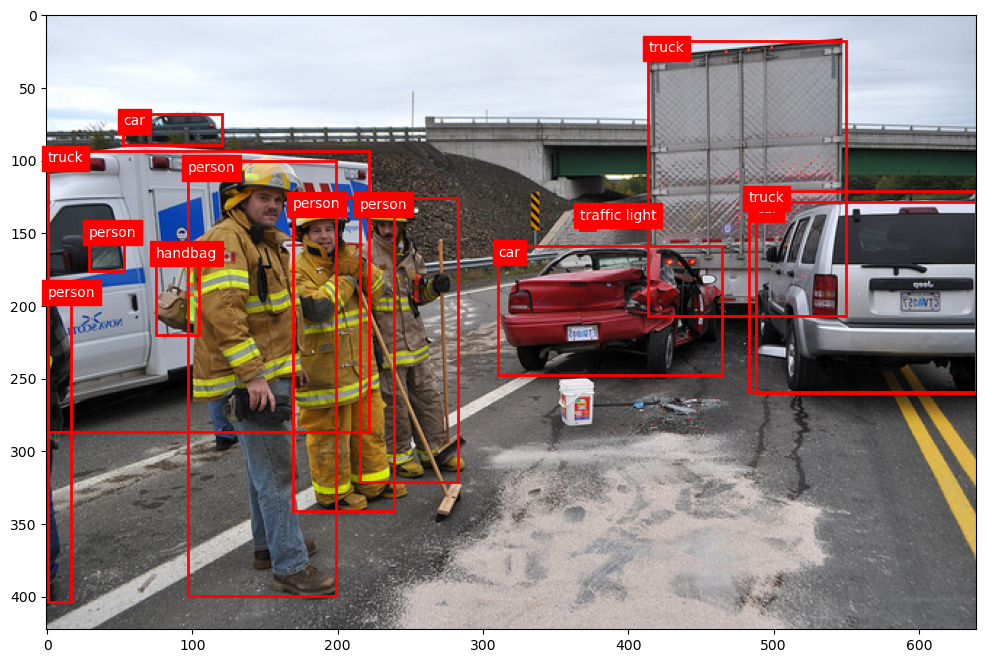

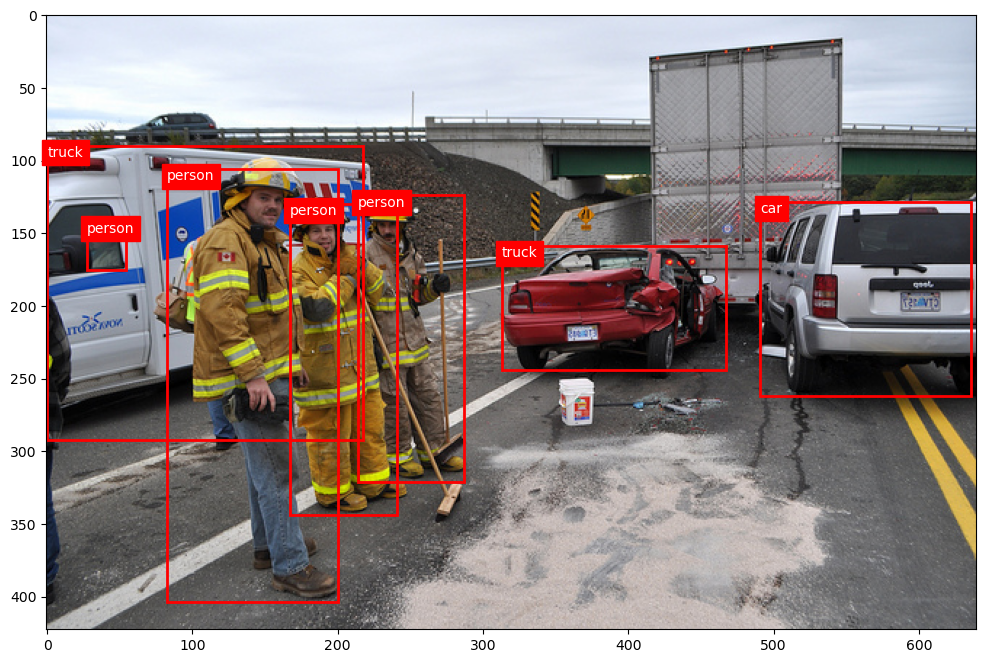

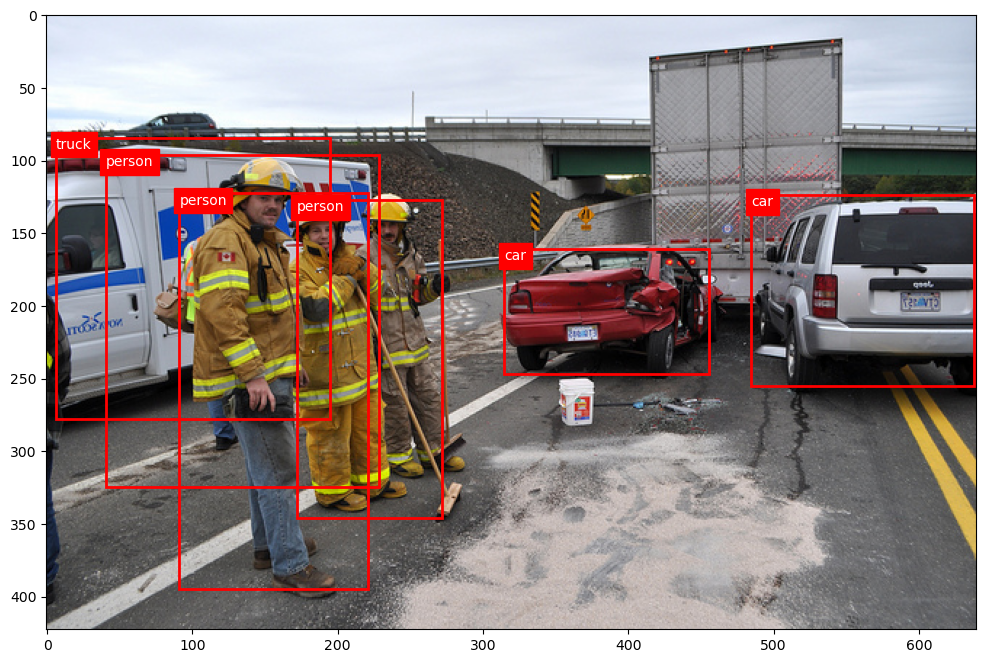

In [8]:
!wget https://www.tejasgokhale.com/images/vehicle.png -O vehicle.jpg
# code to use show_detections to display results for `model0,model1,model2,model3`
# !!!! Complete this

img_path = '/Users/fneba/Desktop/691_Computer_Vision/hw4/vehicle.jpg'

show_detections(img_path, model0, threshold=0.5)
show_detections(img_path, model1, threshold=0.5)
show_detections(img_path, model2, threshold=0.5)
show_detections(img_path, model3, threshold=0.5)

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

In [ ]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

In [9]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [10]:
def iou(box_a, box_b):
    
    xA = max(box_a[0], box_b[0])
    yA = max(box_a[1], box_b[1])
    xB = min(box_a[2], box_b[2])
    yB = min(box_a[3], box_b[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0

    # Compute the area of both bounding boxes
    boxAArea = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    boxBArea = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

def eval_iou(pred_boxes, pred_classes, annotations):
    ious = []
    match_found = False

    for ann in annotations:
        # Make ground truth box and extract the class ID
        gt_bbox = [ann['bbox'][0], ann['bbox'][1], ann['bbox'][0] + ann['bbox'][2], ann['bbox'][1] + ann['bbox'][3]]
        gt_class_id = ann["category_id"]

        for pred_box, pred_class in zip(pred_boxes, pred_classes):
            # Convert predicted class name back to ID for comparison
            pred_class_id = COCO_INSTANCE_CATEGORY_NAMES.index(pred_class) if pred_class in COCO_INSTANCE_CATEGORY_NAMES else -1
            
            # Check if predicted class ID matches ground truth class ID
            if pred_class_id == gt_class_id:
                calculated_iou = iou(pred_box, gt_bbox)
                if calculated_iou > 0:  # Only consider IoU > 0 for meaningful overlaps
                    ious.append(calculated_iou)
                    match_found = True  # A match was found and IoU calculated
                    print(f"Match found: Class {gt_class_id}, IoU = {calculated_iou}")  # Debugging aid
            # if you want to print this you can uncomment but that is tooo much output
            #else:
                #print(f"Class mismatch: GT Class {gt_class_id} ({COCO_INSTANCE_CATEGORY_NAMES[gt_class_id]}), Pred Class {pred_class} ({pred_class_id})")

    if not match_found:
        print("No matches found between predictions and ground truth.")
    
    return np.mean(ious) if ious else 0  # Return 0 if no IoUs to mean


In [11]:
coco_annotations_file="/Users/fneba/Desktop/691_Computer_Vision/hw4/coco_ann2017/annotations/instances_val2017.json"
coco_images_dir="/Users/fneba/Desktop/691_Computer_Vision/hw4/coco_val2017/val2017"
coco= COCOParser(coco_annotations_file, coco_images_dir)

img_ids = coco.get_imgIds()
img_ids = img_ids[:100]

# For mean IoU calculation
mean_ious0 = [] # added for model0
mean_ious1 = [] # added for model1
mean_ious2 = [] # added for model2
mean_ious3 = [] # added for model3

for i, im in enumerate(img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
    image = transform(image)
    pred_boxes0, pred_class0 = get_detection(image, model0) 
    pred_boxes1, pred_class1 = get_detection(image, model1) 
    pred_boxes2, pred_class2 = get_detection(image, model2) 
    pred_boxes3, pred_class3 = get_detection(image, model3) 

    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    # Calculate IoU for each model
    mean_ious0.append(eval_iou(pred_boxes0, pred_class0, annotations))
    mean_ious1.append(eval_iou(pred_boxes1, pred_class1, annotations))
    mean_ious2.append(eval_iou(pred_boxes2, pred_class2, annotations))
    mean_ious3.append(eval_iou(pred_boxes3, pred_class3, annotations))

    
print(f"Mean IoU for model0 over 100 images: {np.mean(mean_ious0)}")   
print(f"Mean IoU for model1 over 100 images: {np.mean(mean_ious1)}") 
print(f"Mean IoU for model2 over 100 images: {np.mean(mean_ious2)}") 
print(f"Mean IoU for model3 over 100 images: {np.mean(mean_ious3)}") 

Match found: Class 67, IoU = 0.840175983113749
Match found: Class 1, IoU = 0.9602033319324337
Match found: Class 51, IoU = 0.9718661625318967
Match found: Class 51, IoU = 0.8856792755891861
Match found: Class 1, IoU = 0.8797540099609222
Match found: Class 47, IoU = 0.7933564410103109
Match found: Class 47, IoU = 0.04189486311648268
Match found: Class 51, IoU = 0.8442381559134289
Match found: Class 51, IoU = 0.8242470479366748
Match found: Class 81, IoU = 0.6247291485265335
Match found: Class 67, IoU = 0.9013879889895274
Match found: Class 1, IoU = 0.9626110588427981
Match found: Class 51, IoU = 0.9450494489064845
Match found: Class 51, IoU = 0.19304880723963175
Match found: Class 51, IoU = 0.9174772162275409
Match found: Class 51, IoU = 0.09022635904861699
Match found: Class 1, IoU = 0.9088048458505072
Match found: Class 47, IoU = 0.7860282876813424
Match found: Class 47, IoU = 0.015614742892296059
Match found: Class 51, IoU = 0.8345021082528178
Match found: Class 51, IoU = 0.863265538

Match found: Class 2, IoU = 0.892543065261802
Match found: Class 3, IoU = 0.8997869647318617
Match found: Class 3, IoU = 0.0036400289024716022
Match found: Class 3, IoU = 0.03955778252553628
Match found: Class 3, IoU = 0.8782475899034824
Match found: Class 10, IoU = 0.7612912258316956
Match found: Class 10, IoU = 0.437617159626486
Match found: Class 3, IoU = 0.0011885336873171583
Match found: Class 3, IoU = 0.8162434555356838
Match found: Class 3, IoU = 0.15915856587345267
Match found: Class 3, IoU = 0.5351798743873691
Match found: Class 3, IoU = 0.5455246105261945
Match found: Class 3, IoU = 0.1627212370192315
Match found: Class 3, IoU = 0.3726601584081163
Match found: Class 3, IoU = 0.9134981385401827
Match found: Class 8, IoU = 0.9159263700740188
Match found: Class 8, IoU = 0.051880191294320914
Match found: Class 2, IoU = 0.833170325650687
Match found: Class 3, IoU = 0.0045000068243579985
Match found: Class 3, IoU = 0.910461391589235
Match found: Class 3, IoU = 0.04018509896529683
M

Match found: Class 70, IoU = 0.8597086388689826
Match found: Class 70, IoU = 0.5229397342002238
Match found: Class 81, IoU = 0.8621854269275717
Match found: Class 81, IoU = 0.43507364560146927
Match found: Class 70, IoU = 0.908273799639896
Match found: Class 70, IoU = 0.3925161636579987
Match found: Class 81, IoU = 0.43108319224931346
Match found: Class 81, IoU = 0.8777283870105262
Match found: Class 70, IoU = 0.9481599717401257
Match found: Class 70, IoU = 0.675797470779639
Match found: Class 81, IoU = 0.42115997086194473
Match found: Class 3, IoU = 0.8157397071649842
Match found: Class 3, IoU = 0.035644972799987594
Match found: Class 3, IoU = 0.8582699250790147
Match found: Class 3, IoU = 0.8003125628539164
Match found: Class 3, IoU = 0.40954102866573927
Match found: Class 4, IoU = 0.9051188571538159
Match found: Class 4, IoU = 0.9059819591946446
Match found: Class 1, IoU = 0.8360448086995077
Match found: Class 1, IoU = 0.07616636210821498
Match found: Class 1, IoU = 0.02409876368656

Match found: Class 64, IoU = 0.8155289535942717
Match found: Class 64, IoU = 0.8948615585625836
Match found: Class 86, IoU = 0.6769978031734057
Match found: Class 86, IoU = 0.8387151331673194
Match found: Class 64, IoU = 0.8739073757151529
Match found: Class 64, IoU = 0.2889144997887664
Match found: Class 64, IoU = 0.927010759944603
Match found: Class 86, IoU = 0.7449039078253509
Match found: Class 86, IoU = 0.7949122116193835
Match found: Class 64, IoU = 0.8594910139578814
Match found: Class 64, IoU = 0.8560073562790778
Match found: Class 86, IoU = 0.7965598219639072
Match found: Class 86, IoU = 0.8359509720063338
Match found: Class 64, IoU = 0.7365606064390967
Match found: Class 72, IoU = 0.912362368552236
Match found: Class 84, IoU = 0.9026713225389916
Match found: Class 84, IoU = 0.06771919838258984
Match found: Class 84, IoU = 0.08317292532235765
Match found: Class 84, IoU = 0.056856445730482
Match found: Class 84, IoU = 0.806306252498365
Match found: Class 84, IoU = 0.19553026605

Match found: Class 20, IoU = 0.7082865094260593
Match found: Class 20, IoU = 0.2015289161902109
Match found: Class 20, IoU = 0.04984871148104184
Match found: Class 20, IoU = 0.3371886896497007
Match found: Class 20, IoU = 0.7480306415851002
Match found: Class 20, IoU = 0.8205411485874264
Match found: Class 20, IoU = 0.06935415041994808
Match found: Class 20, IoU = 0.006677580401752296
Match found: Class 20, IoU = 0.8309400114354791
Match found: Class 20, IoU = 0.09962239415252737
Match found: Class 1, IoU = 0.8146656482807171
Match found: Class 1, IoU = 0.8538537305840891
Match found: Class 20, IoU = 0.6359923273833036
Match found: Class 20, IoU = 0.02629433067262415
Match found: Class 20, IoU = 0.012438249696288203
Match found: Class 20, IoU = 0.8417437622352646
Match found: Class 20, IoU = 0.05475127142595707
Match found: Class 20, IoU = 0.037493294619541234
Match found: Class 20, IoU = 0.9084413964052798
Match found: Class 20, IoU = 0.007281021651148399
Match found: Class 20, IoU = 

Match found: Class 6, IoU = 0.8646778286983261
Match found: Class 27, IoU = 0.8574834010500766
Match found: Class 3, IoU = 0.9544655156297481
Match found: Class 1, IoU = 0.1554113183293872
Match found: Class 1, IoU = 0.7764332139299712
Match found: Class 1, IoU = 0.8582213206726355
Match found: Class 1, IoU = 0.030961016451950867
Match found: Class 1, IoU = 0.1534494029084089
Match found: Class 1, IoU = 0.0895107717660886
Match found: Class 1, IoU = 0.15422868906056403
Match found: Class 1, IoU = 0.05342839245604607
Match found: Class 1, IoU = 0.7086283837806177
Match found: Class 1, IoU = 0.1250221361840211
Match found: Class 1, IoU = 0.1935300346762392
Match found: Class 1, IoU = 0.32918714258089377
Match found: Class 1, IoU = 0.27899573028186075
Match found: Class 1, IoU = 0.054632346295173495
Match found: Class 1, IoU = 0.8179226387261557
Match found: Class 1, IoU = 0.1257548752924545
Match found: Class 1, IoU = 0.9656778329469995
Match found: Class 1, IoU = 0.04934184988303321
Mat

Match found: Class 3, IoU = 0.91781114515843
Match found: Class 3, IoU = 0.745622617261752
Match found: Class 3, IoU = 0.8608355996819006
Match found: Class 6, IoU = 0.94174537270984
Match found: Class 1, IoU = 0.7580077358802497
Match found: Class 3, IoU = 0.7660761440791232
Match found: Class 3, IoU = 0.9387700714830093
Match found: Class 3, IoU = 0.7096562054527668
Match found: Class 3, IoU = 0.8839332858589589
Match found: Class 6, IoU = 0.9447547713352559
Match found: Class 1, IoU = 0.7159571950876127
Match found: Class 3, IoU = 0.8008413672359229
Match found: Class 3, IoU = 0.9500719554958125
Match found: Class 3, IoU = 0.7029598521316456
Match found: Class 3, IoU = 0.8955896873575123
Match found: Class 6, IoU = 0.903578939854889
Match found: Class 1, IoU = 0.7184049488292279
Match found: Class 3, IoU = 0.8077950106860033
Match found: Class 6, IoU = 0.8371319015513694
Match found: Class 3, IoU = 0.009523327337366721
Match found: Class 3, IoU = 0.019432925722586165
Match found: Cl

Match found: Class 7, IoU = 0.8037208715186732
Match found: Class 7, IoU = 0.8521041493853541
Match found: Class 7, IoU = 0.83371307259218
Match found: Class 7, IoU = 0.693784340550488
Match found: Class 7, IoU = 0.9584752622520983
Match found: Class 1, IoU = 0.23745434989898132
Match found: Class 1, IoU = 0.9434438074848216
Match found: Class 1, IoU = 0.06426320840981575
Match found: Class 1, IoU = 0.7613314672753215
Match found: Class 1, IoU = 0.1362763682278716
Match found: Class 1, IoU = 0.45489852685951465
Match found: Class 1, IoU = 0.017933519234239286
Match found: Class 1, IoU = 0.00016540151874846297
Match found: Class 1, IoU = 0.5920282297145504
Match found: Class 7, IoU = 0.9249451741606801
Match found: Class 1, IoU = 0.11444354996971233
Match found: Class 1, IoU = 0.8913884543532408
Match found: Class 1, IoU = 0.4714570799649597
Match found: Class 1, IoU = 0.812204100738775
Match found: Class 1, IoU = 0.11738680275821098
Match found: Class 1, IoU = 0.06662472949535837
Match

Match found: Class 9, IoU = 0.697964730605237
Match found: Class 9, IoU = 0.0011102220547840854
Match found: Class 1, IoU = 0.004371610797670682
Match found: Class 1, IoU = 0.6737604788186836
Match found: Class 1, IoU = 0.7969968017068291
Match found: Class 1, IoU = 0.11818677663162924
Match found: Class 1, IoU = 0.06278900923158359
Match found: Class 1, IoU = 0.11589672961817327
Match found: Class 1, IoU = 0.04833651756120424
Match found: Class 1, IoU = 0.4436816233288399
Match found: Class 1, IoU = 0.9155308487168029
Match found: Class 1, IoU = 0.45091783097136945
Match found: Class 1, IoU = 0.06900778938698175
Match found: Class 1, IoU = 0.6702601289553883
Match found: Class 1, IoU = 0.22214830058405896
Match found: Class 1, IoU = 0.48879021699163244
Match found: Class 1, IoU = 0.0917145244128376
Match found: Class 1, IoU = 0.13953163745201036
Match found: Class 1, IoU = 0.1599757370081354
Match found: Class 1, IoU = 0.4339518297641066
Match found: Class 1, IoU = 0.09110523534398653

Match found: Class 22, IoU = 0.9645770025194503
Match found: Class 22, IoU = 0.9394525957731465
Match found: Class 22, IoU = 0.973431621774233
Match found: Class 22, IoU = 0.9691201775393924
Match found: Class 28, IoU = 0.8219280482010745
Match found: Class 31, IoU = 0.46101664163427947
Match found: Class 31, IoU = 0.3634277523346604
Match found: Class 1, IoU = 0.1559979728202334
Match found: Class 1, IoU = 0.053865127880304474
Match found: Class 1, IoU = 0.8721350200711432
Match found: Class 1, IoU = 0.43280416031751
Match found: Class 1, IoU = 0.6951656695509385
Match found: Class 1, IoU = 0.24951345286288504
Match found: Class 1, IoU = 0.628404785327687
Match found: Class 1, IoU = 0.792380720351214
Match found: Class 1, IoU = 0.13544665249358764
Match found: Class 31, IoU = 0.4450708205608029
Match found: Class 28, IoU = 0.5127773070156875
Match found: Class 28, IoU = 0.9177830988812632
Match found: Class 31, IoU = 0.5039941128353774
Match found: Class 31, IoU = 0.32629101551126344


Match found: Class 19, IoU = 0.9400821365968668
Match found: Class 15, IoU = 0.8098326682741375
Match found: Class 1, IoU = 0.6985944946321222
Match found: Class 1, IoU = 0.649434555569183
Match found: Class 1, IoU = 0.7295838246100614
Match found: Class 1, IoU = 0.05115773003441297
Match found: Class 1, IoU = 0.06388089474332337
Match found: Class 1, IoU = 0.29186060564638866
Match found: Class 1, IoU = 0.7198036651933392
Match found: Class 1, IoU = 0.12788782346647967
Match found: Class 1, IoU = 0.211907084370826
Match found: Class 1, IoU = 0.3194311786133108
Match found: Class 1, IoU = 0.7515899440937349
Match found: Class 1, IoU = 0.21610227079751462
Match found: Class 1, IoU = 0.6828499154444331
Match found: Class 1, IoU = 0.7616823125673883
Match found: Class 28, IoU = 0.7736249825430598
Match found: Class 28, IoU = 0.5689646664103831
Match found: Class 28, IoU = 0.4390070178197868
Match found: Class 28, IoU = 0.16252478270647644
Match found: Class 28, IoU = 0.4887656954441936
Ma

Match found: Class 51, IoU = 0.9614046971171633
Match found: Class 1, IoU = 0.15942066573455727
Match found: Class 1, IoU = 0.400326407294738
Match found: Class 51, IoU = 0.9853288641807488
Match found: Class 1, IoU = 0.1951180176102711
Match found: Class 1, IoU = 0.6160022710411629
No matches found between predictions and ground truth.
Match found: Class 51, IoU = 0.9126699172054171
Match found: Class 56, IoU = 0.03388222954260199
Match found: Class 56, IoU = 0.6768449347914177
Match found: Class 56, IoU = 0.0015720792817273135
Match found: Class 56, IoU = 0.011399962020926366
Match found: Class 56, IoU = 0.018551599221323448
Match found: Class 56, IoU = 0.0359555258796451
Match found: Class 56, IoU = 0.3540541712972586
Match found: Class 56, IoU = 0.19217891376713678
Match found: Class 56, IoU = 0.0014949355746512
Match found: Class 56, IoU = 0.2981617441750084
Match found: Class 56, IoU = 0.01355512298819951
Match found: Class 56, IoU = 0.606821779383647
Match found: Class 56, IoU =

Match found: Class 1, IoU = 0.9545369599275499
Match found: Class 1, IoU = 0.4209658829371288
Match found: Class 41, IoU = 0.6591416574255182
Match found: Class 1, IoU = 0.896415782127057
Match found: Class 41, IoU = 0.8050624512496003
Match found: Class 1, IoU = 0.946404249404349
Match found: Class 41, IoU = 0.7656657486176547
Match found: Class 1, IoU = 0.9106501758288763
Match found: Class 41, IoU = 0.7604635264170847
Match found: Class 1, IoU = 0.8693293054679176
Match found: Class 60, IoU = 0.8594293561981406
Match found: Class 60, IoU = 0.012994948024530256
Match found: Class 60, IoU = 0.05639085170972459
Match found: Class 60, IoU = 0.08290529683540472
Match found: Class 60, IoU = 0.9470011022568048
Match found: Class 60, IoU = 0.15274848710157835
Match found: Class 60, IoU = 0.08586708742569782
Match found: Class 60, IoU = 0.9273549883392695
Match found: Class 60, IoU = 0.0016862289177769258
Match found: Class 60, IoU = 0.17064661259044672
Match found: Class 60, IoU = 0.1459477

Match found: Class 60, IoU = 0.9352000884116951
Match found: Class 60, IoU = 0.02386662026622149
Match found: Class 60, IoU = 0.08829837550825706
Match found: Class 60, IoU = 0.2227802635866016
Match found: Class 60, IoU = 0.03454374901648874
Match found: Class 60, IoU = 0.02092853968056005
Match found: Class 60, IoU = 0.559095970371714
Match found: Class 60, IoU = 0.20600655797820241
Match found: Class 60, IoU = 0.03784235137609217
Match found: Class 60, IoU = 0.9193185357156821
Match found: Class 60, IoU = 0.1885613025187775
Match found: Class 60, IoU = 0.46372573066589645
Match found: Class 60, IoU = 0.030729782012358053
Match found: Class 60, IoU = 0.9344893056855087
Match found: Class 60, IoU = 0.03855784569897839
Match found: Class 60, IoU = 0.48836071466720193
Match found: Class 60, IoU = 0.11192128815552432
Match found: Class 60, IoU = 0.026494071643768286
Match found: Class 60, IoU = 0.025584575108578967
Match found: Class 60, IoU = 0.865878643448124
Match found: Class 60, IoU

Match found: Class 54, IoU = 0.003083027175298264
Match found: Class 54, IoU = 0.8634199850756551
Match found: Class 54, IoU = 0.10056804279941528
Match found: Class 54, IoU = 0.14519884737090055
Match found: Class 54, IoU = 0.8517740647074911
Match found: Class 54, IoU = 0.11155397440754058
Match found: Class 54, IoU = 0.8550290034606318
Match found: Class 54, IoU = 0.037588038933029685
Match found: Class 54, IoU = 0.3335490475955116
Match found: Class 54, IoU = 0.1331182833182072
Match found: Class 54, IoU = 0.30679592888978313
Match found: Class 55, IoU = 0.6716518748334751
Match found: Class 55, IoU = 0.542324289407712
Match found: Class 54, IoU = 0.8938487019746585
Match found: Class 54, IoU = 0.10193116972589585
Match found: Class 54, IoU = 0.13466857996405232
Match found: Class 54, IoU = 0.8790407909992404
Match found: Class 54, IoU = 0.8487974294299422
Match found: Class 54, IoU = 0.02812628237205152
Match found: Class 54, IoU = 0.1161046863587129
Match found: Class 55, IoU = 0

Match found: Class 1, IoU = 0.9070155093693623
Match found: Class 1, IoU = 0.21719110138282452
Match found: Class 1, IoU = 0.04703060922487769
Match found: Class 1, IoU = 0.19228731674752605
Match found: Class 1, IoU = 0.9067589108496097
Match found: Class 1, IoU = 0.9508335181514448
Match found: Class 1, IoU = 0.20847094647758216
Match found: Class 1, IoU = 0.04959505244584992
Match found: Class 1, IoU = 0.1771974590925281
Match found: Class 1, IoU = 0.9242809911107026
Match found: Class 61, IoU = 0.6478956589300678
Match found: Class 1, IoU = 0.16582935542376503
Match found: Class 1, IoU = 0.9707867538188729
Match found: Class 1, IoU = 0.051059221407300764
Match found: Class 1, IoU = 0.956307101897786
Match found: Class 1, IoU = 0.1774446703949712
Match found: Class 61, IoU = 0.7323449074207242
Match found: Class 1, IoU = 0.827464794412814
Match found: Class 1, IoU = 0.19841570928891297
Match found: Class 1, IoU = 0.1279298337053428
Match found: Class 1, IoU = 0.9438250849318387
Matc

Match found: Class 65, IoU = 0.8080495476262851
Match found: Class 65, IoU = 0.46364166107469196
Match found: Class 65, IoU = 0.7585509203378243
Match found: Class 65, IoU = 0.46913089789230566
Match found: Class 65, IoU = 0.857992455141955
Match found: Class 65, IoU = 0.365456620666333
Match found: Class 65, IoU = 0.9366096434910312
Match found: Class 65, IoU = 0.8065550170692214
Match found: Class 65, IoU = 0.3291375575496553
Match found: Class 1, IoU = 0.5208720202454438
Match found: Class 65, IoU = 0.8878796086467581
Match found: Class 65, IoU = 0.4438657227852404
Match found: Class 1, IoU = 0.3996000586631653
Match found: Class 1, IoU = 0.6121554853207938
Match found: Class 65, IoU = 0.6963772735047897
No matches found between predictions and ground truth.
Match found: Class 59, IoU = 0.8520630852040316
Match found: Class 59, IoU = 0.9164337468149271
Match found: Class 59, IoU = 0.9248327054904877
Match found: Class 59, IoU = 0.9331317959387564
Match found: Class 42, IoU = 0.85179

Match found: Class 37, IoU = 0.8651687375046965
Match found: Class 43, IoU = 0.890915667201385
Match found: Class 1, IoU = 0.9346256162657777
Match found: Class 1, IoU = 0.8200571871324969
Match found: Class 1, IoU = 0.005991620721628063
Match found: Class 1, IoU = 0.02050958754602438
Match found: Class 1, IoU = 0.9150303227483549
Match found: Class 1, IoU = 0.0855795108206642
Match found: Class 1, IoU = 0.21438311496599952
Match found: Class 1, IoU = 0.06169806203903908
Match found: Class 1, IoU = 0.007002760128951071
Match found: Class 1, IoU = 0.8995561610456783
Match found: Class 1, IoU = 0.018446522572470866
Match found: Class 1, IoU = 0.3574780997825675
Match found: Class 1, IoU = 0.03687585110722317
Match found: Class 1, IoU = 0.6507044778189689
Match found: Class 1, IoU = 0.037871312432453556
Match found: Class 1, IoU = 0.7004526202184417
Match found: Class 1, IoU = 0.31085648050086245
Match found: Class 1, IoU = 0.3366798672811109
Match found: Class 1, IoU = 0.585214429618255


In [15]:
def calculate_matches(pred_boxes, pred_classes, annotations, iou_threshold=0.5):
    TP = 0
    FP = 0
    FN = 0

    matched_gt_indices = set()  # Keep track of matched ground truth indices

    # Check each prediction for potential matches
    for pred_box, pred_class in zip(pred_boxes, pred_classes):
        found_match = False
        for idx, ann in enumerate(annotations):
            gt_bbox = [ann['bbox'][0], ann['bbox'][1], ann['bbox'][0] + ann['bbox'][2], ann['bbox'][1] + ann['bbox'][3]]
            gt_class_id = ann["category_id"]
            pred_class_id = COCO_INSTANCE_CATEGORY_NAMES.index(pred_class) if pred_class in COCO_INSTANCE_CATEGORY_NAMES else -1

            if pred_class_id == gt_class_id and iou(pred_box, gt_bbox) >= iou_threshold:
                if idx not in matched_gt_indices:
                    matched_gt_indices.add(idx)
                    found_match = True
                    TP += 1
                    break

        if not found_match:
            FP += 1

    # Compute FN as ground truths that were not matched
    FN = len(annotations) - len(matched_gt_indices)
    
    return TP, FP, FN


In [16]:
models = [model0, model1, model2, model3]

TPs = [0, 0, 0, 0]  # TP for model0, model1, model2, model3
FPs = [0, 0, 0, 0]  # FP for model0, model1, model2, model3
FNs = [0, 0, 0, 0]  # FN for model0, model1, model2, model3

for im in img_ids:
    image_path = f"{coco_images_dir}/{str(im).zfill(12)}.jpg"
    image = Image.open(image_path).convert('RGB')
    image = transform(image)

    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)

    for idx, model in enumerate(models):
        pred_boxes, pred_classes = get_detection(image, model)
        tp, fp, fn = calculate_matches(pred_boxes, pred_classes, annotations)
        TPs[idx] += tp
        FPs[idx] += fp
        FNs[idx] += fn

for idx, model in enumerate(models):
    precision = TPs[idx] / (TPs[idx] + FPs[idx]) if TPs[idx] + FPs[idx] > 0 else 0
    recall = TPs[idx] / (TPs[idx] + FNs[idx]) if TPs[idx] + FNs[idx] > 0 else 0
    print(f"Precision for model{idx}: {precision:.2f}")
    print(f"Recall for model{idx}: {recall:.2f}")

Precision for model0: 0.50
Recall for model0: 0.71
Precision for model1: 0.52
Recall for model1: 0.74
Precision for model2: 0.76
Recall for model2: 0.53
Precision for model3: 0.80
Recall for model3: 0.26
